In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import geopandas as gpd
import shapely
import json
from shapely.geometry import Point
from fiona.crs import from_epsg
import pylab as pl
%matplotlib inline
import unicodedata
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import scipy as sp
from scipy import stats

# 1. Download and prepare the data

## 1.1 Download 2015 NYC Community Income Data and process a dataframe of 2015 Manhattan Households Median Income (dollars) by zipcode

In [75]:
!wget 'https://raw.githubusercontent.com/Chang-Du/PUI2018_cd2682/master/ExtraCreditProject_cd2682/ACS_15_5YR_S1901/ACS_15_5YR_S1901_with_ann.csv'

--2018-12-08 15:11:06--  https://raw.githubusercontent.com/Chang-Du/PUI2018_cd2682/master/ExtraCreditProject_cd2682/ACS_15_5YR_S1901/ACS_15_5YR_S1901_with_ann.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46367 (45K) [text/plain]
Saving to: ‘ACS_15_5YR_S1901_with_ann.csv.1’

ACS_15_5YR_S1901_wi 100%[===================>]  45.28K  --.-KB/s    in 0.002s  

2018-12-08 15:11:06 (25.5 MB/s) - ‘ACS_15_5YR_S1901_with_ann.csv.1’ saved [46367/46367]



In [3]:
!mv 'ACS_15_5YR_S1901_with_ann.csv' $PUIDATA

In [4]:
# 2016 New York Income data - AFF
income = pd.read_csv(os.getenv("PUIDATA") + "/ACS_15_5YR_S1901_with_ann.csv", skiprows=1, header=0)
income = income.drop([0])
income = income.reset_index(drop = True)
income.shape

(70, 131)

In [5]:
income.head()

,Id,Id2,Geography,Households; Estimate; Total,Households; Margin of Error; Total,Families; Estimate; Total,Families; Margin of Error; Total,Married-couple families; Estimate; Total,Married-couple families; Margin of Error; Total,Nonfamily households; Estimate; Total,...,Nonfamily households; Estimate; PERCENT IMPUTED - Family income in the past 12 months,Nonfamily households; Margin of Error; PERCENT IMPUTED - Family income in the past 12 months,Households; Estimate; PERCENT IMPUTED - Nonfamily income in the past 12 months,Households; Margin of Error; PERCENT IMPUTED - Nonfamily income in the past 12 months,Families; Estimate; PERCENT IMPUTED - Nonfamily income in the past 12 months,Families; Margin of Error; PERCENT IMPUTED - Nonfamily income in the past 12 months,Married-couple families; Estimate; PERCENT IMPUTED - Nonfamily income in the past 12 months,Married-couple families; Margin of Error; PERCENT IMPUTED - Nonfamily income in the past 12 months,Nonfamily households; Estimate; PERCENT IMPUTED - Nonfamily income in the past 12 months,Nonfamily households; Margin of Error; PERCENT IMPUTED - Nonfamily income in the past 12 months
0,8600000US10001,10001,ZCTA5 10001,11639,506,3668,451,2734,412,7971,...,(X),(X),(X),(X),(X),(X),(X),(X),19.6,(X)
1,8600000US10002,10002,ZCTA5 10002,33348,548,17572,657,9991,617,15776,...,(X),(X),(X),(X),(X),(X),(X),(X),26.7,(X)
2,8600000US10003,10003,ZCTA5 10003,27487,679,7331,581,6135,511,20156,...,(X),(X),(X),(X),(X),(X),(X),(X),21.7,(X)
3,8600000US10004,10004,ZCTA5 10004,1574,201,591,137,502,120,983,...,(X),(X),(X),(X),(X),(X),(X),(X),23.5,(X)
4,8600000US10005,10005,ZCTA5 10005,4252,396,1270,274,1127,279,2982,...,(X),(X),(X),(X),(X),(X),(X),(X),24.7,(X)


In [6]:
# keep zipcode and households income two columns and resetindex
income_median = income[['Id2','Households; Estimate; Median income (dollars)']].dropna()
income_median.rename(columns={"Households; Estimate; Median income (dollars)": "Households Median Income (dollars)",
                              "Id2": "Zipcode"}, inplace=True)
income_median = income_median.reset_index(drop = True)
income_median.head()

,Zipcode,Households Median Income (dollars)
0,10001,86801
1,10002,33726
2,10003,98151
3,10004,119691
4,10005,124194


In [7]:
# Manhattan zipcode list
man_zipcode = [10026, 10027, 10030, 10037, 10039, 10001, 10011, 10018, 10019, 10020, 10036, 10029, 10035, 10010, 
               10016, 10017, 10022, 10012, 10013, 10014, 10004, 10005, 10006, 10007, 10038, 10280, 10002, 10003, 
               10009, 10021, 10028, 10044, 10065, 10075, 10128, 10023, 10024, 10025, 10031, 10032, 10033, 10034, 10040]

In [8]:
# create df of Manhattan households median income sort by zipcode
man_income_median = income_median[income_median['Zipcode'].isin(man_zipcode)]
man_income_median = man_income_median.reset_index(drop = True)
man_income_median.head()

,Zipcode,Households Median Income (dollars)
0,10001,86801
1,10002,33726
2,10003,98151
3,10004,119691
4,10005,124194


## 1.2 Download the zillow 1B1B rental price data and process a dataframe of 2015 NYC Manhattan rental price by zipcode

In [9]:
# download the zillow rental price data: 1b1b by zip
!wget 'http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_1Bedroom.csv'
!mv Zip_MedianRentalPrice_1Bedroom.csv $PUIDATA

--2018-12-14 20:19:15--  http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_1Bedroom.csv
Resolving files.zillowstatic.com (files.zillowstatic.com)... 13.249.44.47, 13.249.44.93, 13.249.44.126, ...
Connecting to files.zillowstatic.com (files.zillowstatic.com)|13.249.44.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416509 (407K) [binary/octet-stream]
Saving to: ‘Zip_MedianRentalPrice_1Bedroom.csv’

Zip_MedianRentalPri 100%[===================>] 406.75K  --.-KB/s    in 0.05s   

2018-12-14 20:19:15 (8.05 MB/s) - ‘Zip_MedianRentalPrice_1Bedroom.csv’ saved [416509/416509]



In [10]:
rental = pd.read_csv(os.getenv("PUIDATA") + "/Zip_MedianRentalPrice_1Bedroom.csv")
rental.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
0,10025,New York,NY,New York-Newark-Jersey City,New York County,1,NaN,2600.0,2639.0,2678.0,...,3025.0,3025.0,2997.5,2955.5,2995.0,2995.0,2928.0,2900.0,2950.0,2995.0
1,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,NaN,NaN,NaN,NaN,...,1400.0,1440.0,1425.0,1445.0,1450.0,1450.0,1450.0,1400.0,1370.0,1350.0
2,10023,New York,NY,New York-Newark-Jersey City,New York County,3,NaN,3072.5,3050.0,3000.0,...,3295.0,3295.0,3225.5,3295.0,3300.0,3300.0,3300.0,3300.0,3300.0,3300.0
3,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,NaN,NaN,NaN,NaN,...,1179.0,1175.0,1190.0,1205.0,1200.0,1178.0,1209.0,1207.0,1179.5,1249.0
4,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,NaN,NaN,NaN,NaN,...,1575.0,1613.0,1595.0,1599.0,1600.0,1595.0,1579.5,1595.0,1570.0,1550.0


In [11]:
# only choose the manhattan rental data of 2015 by zipcode
manrental = rental[rental['CountyName'] == 'New York County']
manrental2015 = manrental[manrental.columns[58:70]]
manrental_zip = pd.DataFrame(manrental[manrental.columns[0]])
man_rental = manrental_zip.merge(manrental2015, how = 'outer',left_index = True, right_index = True).dropna().reset_index(drop = True)
man_rental.head()
# man_rental.shape (43, 13)

,RegionName,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,10025,3100.0,3100.0,3112.5,3195.0,3045.0,2995.0,3000.0,3069.0,3100.0,3050.0,3091.5,3012.5
1,10023,3300.0,3300.0,3350.0,3375.0,3300.0,3300.0,3350.0,3350.0,3350.0,3300.0,3300.0,3300.0
2,10002,2562.5,2595.0,2595.0,2500.0,2500.0,2650.0,2650.0,2650.0,2695.0,2625.0,2650.0,2650.0
3,10016,3395.0,3419.0,3442.5,3450.0,3420.0,3450.0,3450.0,3450.0,3450.0,3400.0,3395.0,3350.0
4,10009,2895.0,2895.0,2895.0,2700.0,2695.0,2795.0,2795.0,2800.0,2979.0,2900.0,2850.0,2824.0


In [12]:
# Calculate the average rental price of 2015
man_rental_zip = pd.DataFrame(man_rental[man_rental.columns[0]])
manrental_avgn = pd.DataFrame(man_rental.iloc[:,1:].mean(axis = 1), columns = ['2015 Average Rental'])
manrental_avg = man_rental_zip.merge(manrental_avgn, how = 'outer',
                                     left_index = True, right_index = True).reset_index(drop = True).rename(
    columns={'RegionName': 'Zipcode'})

manrental_avg.head()

,Zipcode,2015 Average Rental
0,10025,3072.541667
1,10023,3322.916667
2,10002,2610.208333
3,10016,3422.625000
4,10009,2835.250000


## 1.3 Download the NYC Zipcode shapfile and plot

In [134]:
!wget -c 'https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip' -O 'zipcode shapfile.zip'

--2018-12-09 20:26:09--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.205, 52.206.68.26, 52.206.140.199
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘zipcode shapfile.zip’

zipcode shapfile.zi     [    <=>             ]   1.44M  1.93MB/s    in 0.7s    

2018-12-09 20:26:10 (1.93 MB/s) - ‘zipcode shapfile.zip’ saved [1514401]



In [135]:
!unzip 'zipcode shapfile.zip' -d $PUIDATA

Archive:  zipcode shapfile.zip
replace /nfshome/cd2682/PUIdata/ZIP_CODE_040114.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


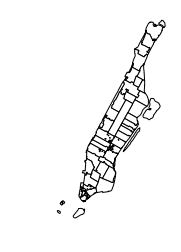

In [13]:
# plot the Manhattan zipcode
zipshape = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
zipshape = zipshape[zipshape['COUNTY'] == 'New York']
ax = zipshape.plot(color='white', edgecolor='black')
ax.axis('off');

Figure1: The shape of NYC Manhatta zipcode zone.

## 1.4 Download 2015 Tree Census Data and process dataframe of 2015 Manhattan tree census, tree health and tree diameter

In [80]:
!wget -c 'https://data.cityofnewyork.us/api/views/5rq2-4hqu/rows.csv?accessType=DOWNLOAD' -O 'trees2016.csv'

--2018-12-08 15:45:20--  https://data.cityofnewyork.us/api/views/5rq2-4hqu/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘trees2016.csv’

trees2016.csv           [        <=>         ] 225.09M  4.58MB/s    in 49s     

2018-12-08 15:46:09 (4.60 MB/s) - ‘trees2016.csv’ saved [236024379]



In [81]:
!mv trees2016.csv $PUIDATA

In [14]:
trees = pd.read_csv(os.getenv("PUIDATA") + "/trees2016.csv")
trees.shape

(683788, 42)

In [15]:
trees.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [16]:
trees.columns

Index(['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trnk_wire', 'trnk_light', 'trnk_other',
       'brnch_ligh', 'brnch_shoe', 'brnch_othe', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'cncldist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'Latitude',
       'longitude', 'x_sp', 'y_sp'],
      dtype='object')

In [17]:
# pick out manhattan trees by boroname
mantrees = trees[trees['boroname'] == 'Manhattan'].reset_index(drop = True)
mantrees.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/30/2015,190422,106099,POINT (-73.98494997200308 40.770045625891846),11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,67,27,MN14,Lincoln Square,1014500,New York,40.770046,-73.984950,988418.699656,219825.522669
1,08/30/2015,190426,106099,POINT (-73.98533807200513 40.77020969000546),11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,67,27,MN14,Lincoln Square,1014500,New York,40.770210,-73.985338,988311.190028,219885.278455
2,09/07/2015,208649,103940,POINT (-73.98729652382876 40.7627238542921),9,0,OnCurb,Alive,Good,Tilia americana,...,75,27,MN15,Clinton,1012700,New York,40.762724,-73.987297,987769.116309,217157.856088
3,08/31/2015,193310,107600,POINT (-73.96045570742453 40.77217147708009),14,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,73,28,MN40,Upper East Side-Carnegie Hill,1012800,New York,40.772171,-73.960456,995203.003673,220602.155302
4,09/03/2015,199760,107038,POINT (-73.98096427881879 40.78208719997997),4,0,OnCurb,Alive,Fair,Quercus phellos,...,67,29,MN12,Upper West Side,1016300,New York,40.782087,-73.980964,989521.741413,224212.887582


In [18]:
mantrees['lonlat'] = list(zip(mantrees.longitude, mantrees.Latitude))
mantrees['geometry'] = mantrees[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [19]:
# Manhattan trees
mantrees = gpd.GeoDataFrame(mantrees)
mantrees.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp,lonlat,geometry
0,08/30/2015,190422,106099,POINT (-73.98494997200308 40.770045625891846),11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,MN14,Lincoln Square,1014500,New York,40.770046,-73.984950,988418.699656,219825.522669,"(-73.98494997, 40.77004563)",POINT (-73.98494997 40.77004563)
1,08/30/2015,190426,106099,POINT (-73.98533807200513 40.77020969000546),11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,MN14,Lincoln Square,1014500,New York,40.770210,-73.985338,988311.190028,219885.278455,"(-73.98533807, 40.77020969)",POINT (-73.98533807 40.77020969)
2,09/07/2015,208649,103940,POINT (-73.98729652382876 40.7627238542921),9,0,OnCurb,Alive,Good,Tilia americana,...,MN15,Clinton,1012700,New York,40.762724,-73.987297,987769.116309,217157.856088,"(-73.98729652, 40.76272385)",POINT (-73.98729652 40.76272385)
3,08/31/2015,193310,107600,POINT (-73.96045570742453 40.77217147708009),14,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,MN40,Upper East Side-Carnegie Hill,1012800,New York,40.772171,-73.960456,995203.003673,220602.155302,"(-73.96045571, 40.77217148)",POINT (-73.96045571000001 40.77217148)
4,09/03/2015,199760,107038,POINT (-73.98096427881879 40.78208719997997),4,0,OnCurb,Alive,Fair,Quercus phellos,...,MN12,Upper West Side,1016300,New York,40.782087,-73.980964,989521.741413,224212.887582,"(-73.98096428, 40.7820872)",POINT (-73.98096427999999 40.78208720000001)


In [20]:
# Manhattan Trees' health 
mantrees_health = mantrees[['zipcode','health','geometry']].dropna()
mantrees_health['health'] = mantrees_health['health'].map({'Poor':0, 'Fair':1, 'Good':2})
mantrees_health.head()

,zipcode,health,geometry
0,10023,2,POINT (-73.98494997 40.77004563)
1,10023,2,POINT (-73.98533807 40.77020969)
2,10019,2,POINT (-73.98729652 40.76272385)
3,10021,2,POINT (-73.96045571000001 40.77217148)
4,10024,1,POINT (-73.98096427999999 40.78208720000001)


In [21]:
# Manhttan trees' diameter
mantrees_d = mantrees[['zipcode','tree_dbh','geometry']].dropna()
mantrees_d.head()

,zipcode,tree_dbh,geometry
0,10023,11,POINT (-73.98494997 40.77004563)
1,10023,11,POINT (-73.98533807 40.77020969)
2,10019,9,POINT (-73.98729652 40.76272385)
3,10021,14,POINT (-73.96045571000001 40.77217148)
4,10024,4,POINT (-73.98096427999999 40.78208720000001)


# 2. Plot the Manhattan trees, tree health level, tree diameter

In [22]:
mantrees.crs = from_epsg(4326)

In [27]:
mantrees_health['health'] = mantrees_health['health'].astype(int)
mantrees_d['tree_dbh'] = mantrees_d['tree_dbh'].astype(int)

Text(0.5,69,'longitude (deg)')

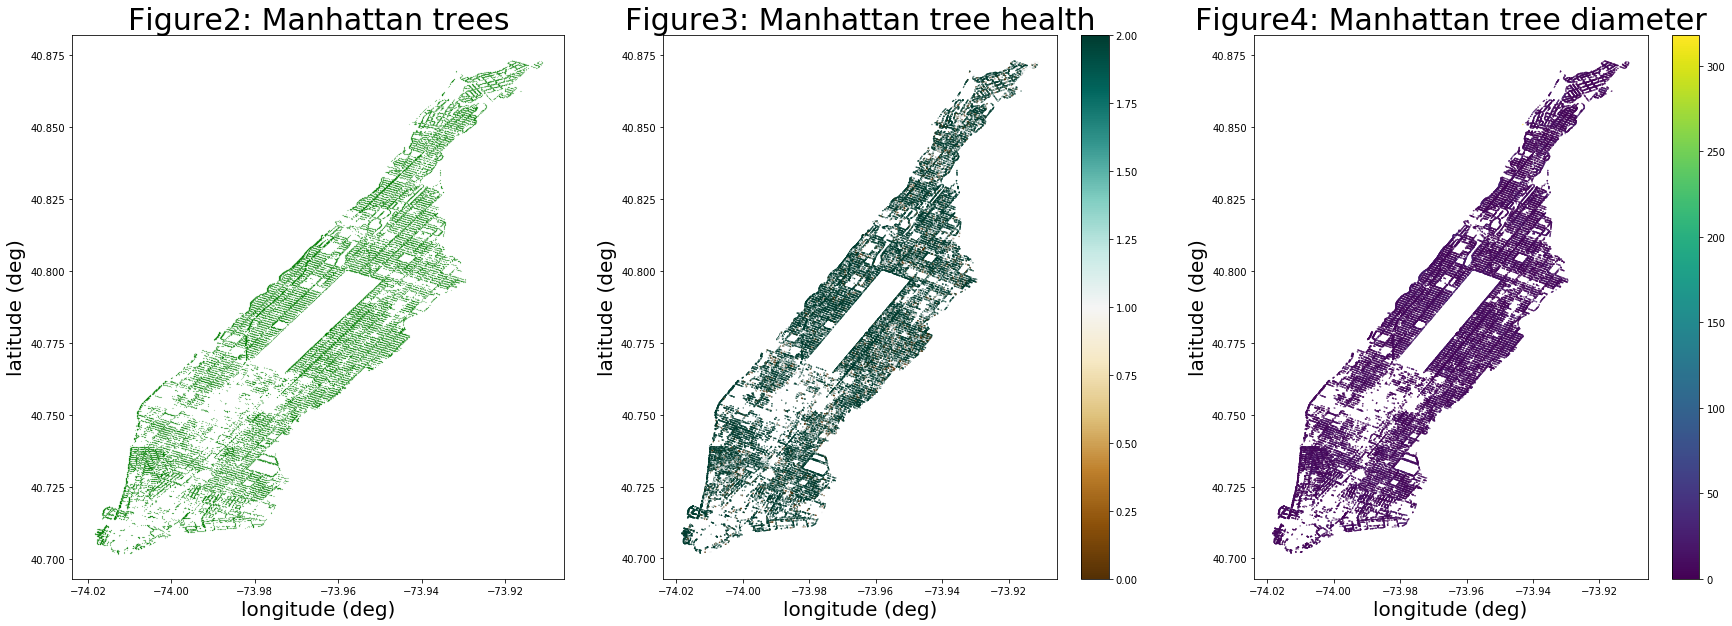

In [30]:
# plot the Manhattan trees to see distribution feastures
fig = pl.figure(figsize=(30,10))

ax1 = fig.add_subplot(131)
ax1.set_title('Figure2: Manhattan trees', fontsize=30)
mantrees.plot(markersize=0.01, color='green', ax=ax1, legend=True)
ax1.set_ylabel("latitude (deg)", fontsize=20)
ax1.set_xlabel("longitude (deg)", fontsize=20)

ax2 = fig.add_subplot(132)
ax2.set_title('Figure3: Manhattan tree health', fontsize=30)
mantrees_health.plot(column='health', cmap='BrBG', markersize=0.1, ax=ax2, legend=True)
ax2.set_ylabel("latitude (deg)", fontsize=20)
ax2.set_xlabel("longitude (deg)", fontsize=20)

ax3 = fig.add_subplot(133)
ax3.set_title('Figure4: Manhattan tree diameter', fontsize=30)
mantrees_d.plot(column='tree_dbh', markersize=0.1, ax=ax3, legend=True)
ax3.set_ylabel("latitude (deg)", fontsize=20)
ax3.set_xlabel("longitude (deg)", fontsize=20)

Caption: 

Figure2: 2015 NYC Manhattan trees census: plot the location of every tree but trees in some parks (e.g. Central Park) are excluded. 

Figure3: Manhattan trees health distribution, we can see the trees are in good health.

Figure4: Manhattan tree diameter distribution for every tree. The distribution is even.

# 2.  Calculate the number of trees by each zipcode, and further calculate the average health level and average diameter of trees.

In [32]:
# Calculate the total number of trees by each zipcode
ntrees = mantrees.groupby("zipcode").count().reset_index()[["zipcode", "geometry"]].rename(
    columns={'geometry': 'ntrees'})
ntrees.dropna(subset=["ntrees"], inplace=True)
ntrees['zipcode'] = ntrees.zipcode.astype(int)
ntrees = ntrees.drop([0]).reset_index(drop = True)
ntrees.head()

,zipcode,ntrees
0,10001,911
1,10002,2265
2,10003,2025
3,10004,118
4,10005,144


In [33]:
# calculate the average tree health level by the total number of trees by each zipcode
treehealth_avg = mantrees_health.groupby("zipcode").mean().reset_index()[["zipcode", "health"]].rename(
    columns={'health': 'treehealth_avg'})
treehealth_avg.dropna(subset=["treehealth_avg"], inplace=True)
treehealth_avg['zipcode'] = treehealth_avg.zipcode.astype(int)
treehealth_avg = treehealth_avg.drop([0]).reset_index(drop = True)
treehealth_avg.head()

,zipcode,treehealth_avg
0,10001,1.809412
1,10002,1.714087
2,10003,1.709213
3,10004,1.803419
4,10005,1.346154


In [34]:
# calculate the average tree diameter by the total number of trees by each zipcode
treed_avg = mantrees_d.groupby("zipcode").mean().reset_index()[["zipcode", "tree_dbh"]].rename(
    columns={'tree_dbh': 'tree_diameter_avg'})
treed_avg.dropna(subset=["tree_diameter_avg"], inplace=True)
treed_avg['zipcode'] = treed_avg.zipcode.astype(int)
treed_avg = treed_avg.drop([0]).reset_index(drop = True)
treed_avg.head()

,zipcode,tree_diameter_avg
0,10001,7.082327
1,10002,8.237528
2,10003,8.802469
3,10004,6.601695
4,10005,5.840278


# 3. Merge all data on zipcode

Merge man_income_median, manrental_avg, mantrees, ntrees, treehealth_avg, treed_avg
So every zipcode has the data of:
1. number of trees 
2. the average tree health
3. the average tree diameter
4. median households income 
5. average rental price

In [35]:
income_rental = man_income_median.merge(manrental_avg, how='inner')
income_rental.head()

,Zipcode,Households Median Income (dollars),2015 Average Rental
0,10001,86801,3841.125000
1,10002,33726,2610.208333
2,10003,98151,3390.958333
3,10004,119691,3849.458333
4,10005,124194,3731.166667


In [36]:
tree_condition = treehealth_avg.merge(treed_avg, how='inner')
tree_condition.head()

,zipcode,treehealth_avg,tree_diameter_avg
0,10001,1.809412,7.082327
1,10002,1.714087,8.237528
2,10003,1.709213,8.802469
3,10004,1.803419,6.601695
4,10005,1.346154,5.840278


In [37]:
tree_total = tree_condition.merge(ntrees, how='inner')
tree_total.head()

,zipcode,treehealth_avg,tree_diameter_avg,ntrees
0,10001,1.809412,7.082327,911
1,10002,1.714087,8.237528,2265
2,10003,1.709213,8.802469,2025
3,10004,1.803419,6.601695,118
4,10005,1.346154,5.840278,144


In [38]:
income_rental = income_rental.rename(columns={'Zipcode': 'zipcode'})
tree_econ = tree_total.merge(income_rental, how='inner')
tree_econ.head()

,zipcode,treehealth_avg,tree_diameter_avg,ntrees,Households Median Income (dollars),2015 Average Rental
0,10001,1.809412,7.082327,911,86801,3841.125000
1,10002,1.714087,8.237528,2265,33726,2610.208333
2,10003,1.709213,8.802469,2025,98151,3390.958333
3,10004,1.803419,6.601695,118,119691,3849.458333
4,10005,1.346154,5.840278,144,124194,3731.166667


In [39]:
zipshape['ZIPCODE'] = zipshape.ZIPCODE.astype(int)

In [45]:
tree_econ_shape = zipshape[['ZIPCODE', 'geometry']].merge(tree_econ, left_on='ZIPCODE', right_on='zipcode')
tree_econ_shape.head()

,ZIPCODE,geometry,zipcode,treehealth_avg,tree_diameter_avg,ntrees,Households Median Income (dollars),2015 Average Rental
0,10034,"POLYGON ((1006203.169008225 257345.6566181332,...",10034,1.596282,6.874841,1574,42581.0,1438.625000
1,10033,"POLYGON ((1003020.86467731 256049.1618358046, ...",10033,1.628510,7.845764,1971,44933.0,1634.583333
2,10040,"POLYGON ((1002564.135275811 253724.7731118798,...",10040,1.627154,7.171154,1560,46200.0,1538.416667
3,10032,"POLYGON ((998935.8528342247 249154.259943217, ...",10032,1.631274,7.994587,2217,37280.0,1687.083333
4,10031,"POLYGON ((1000830.038678393 241801.5896092206,...",10031,1.727199,8.450715,2587,39774.0,1721.000000


# 4. Map each variables: number of trees, average tree health, average tree diameter, median community household income, average rental price.

In [41]:
# convert households income into float
tree_econ_shape.loc[tree_econ_shape['ZIPCODE'] == 10007,'Households Median Income (dollars)'] = 250000
tree_econ_shape['Households Median Income (dollars)'] = tree_econ_shape[
    'Households Median Income (dollars)'].astype(float)

In [42]:
tree_econ.loc[tree_econ['zipcode'] == 10007,'Households Median Income (dollars)'] = 250000
tree_econ['Households Median Income (dollars)'] = tree_econ[
    'Households Median Income (dollars)'].astype(float)

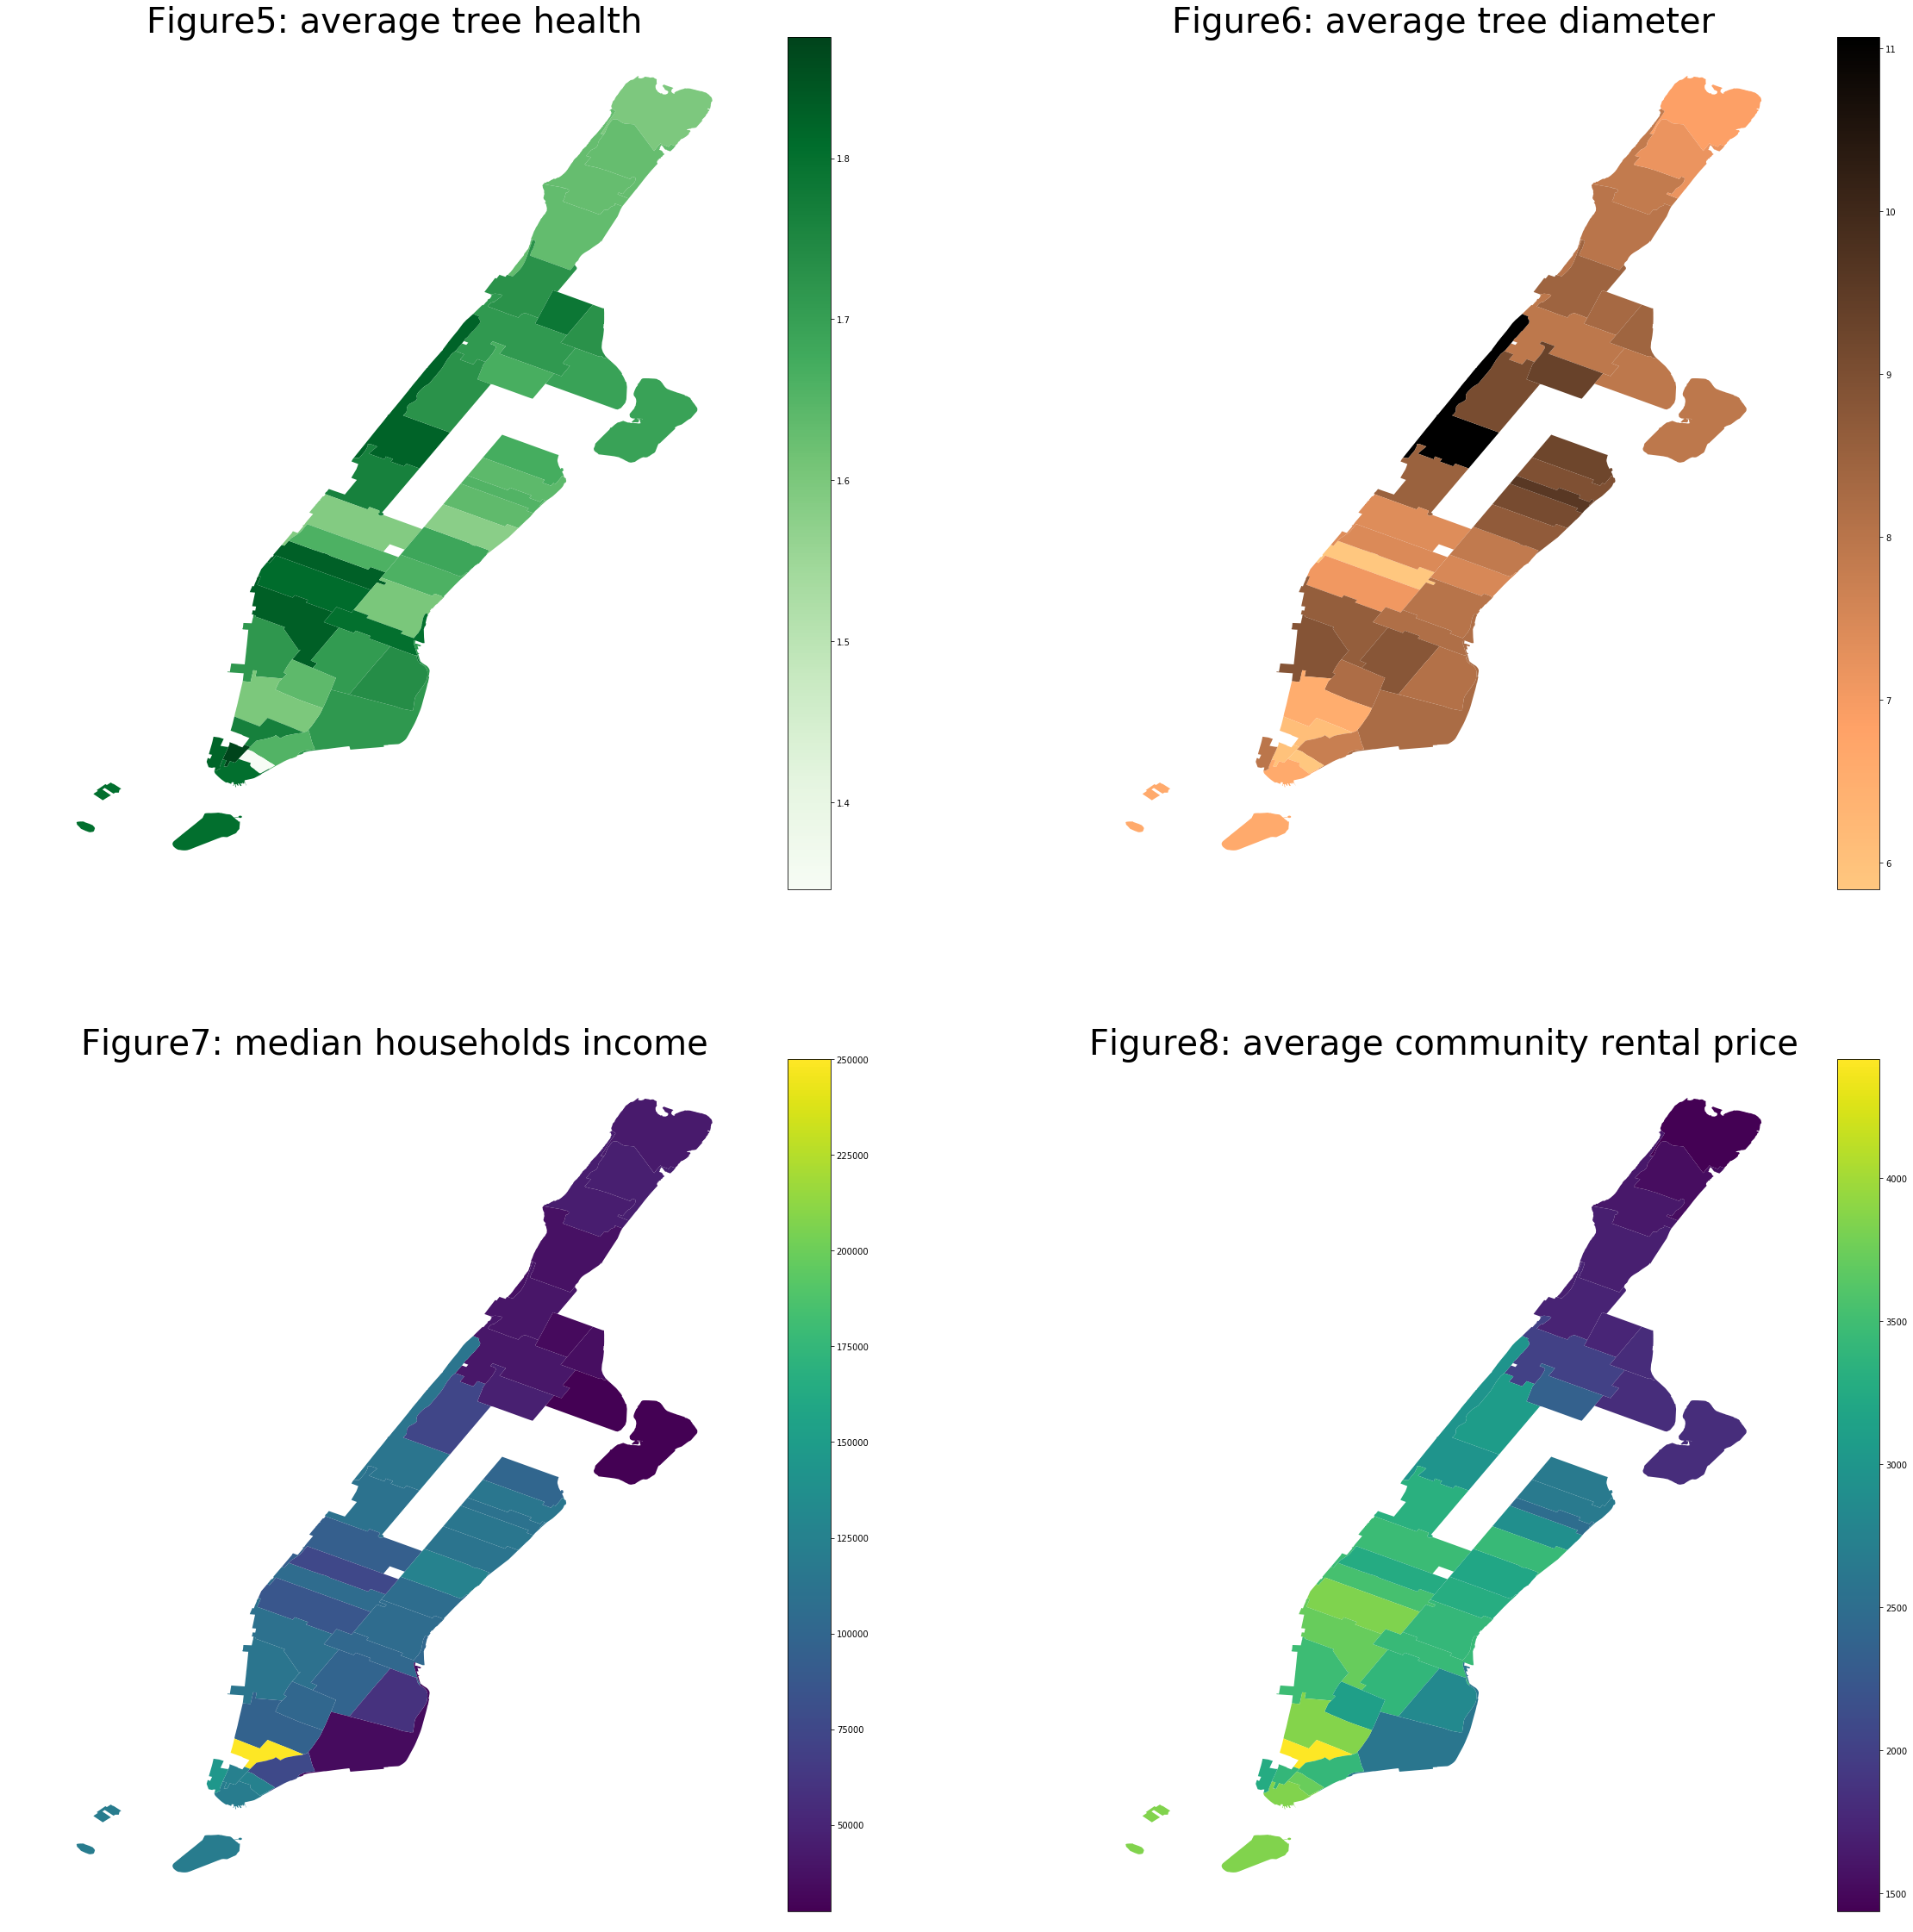

In [46]:
fig = pl.figure(figsize=(40,40))

ax1 = fig.add_subplot(221)
ax1.set_title('Figure5: average tree health', fontsize=40)
tree_econ_shape.plot(column='treehealth_avg', cmap='Greens', ax=ax1, legend=True)
ax1.axis('off')

ax2 = fig.add_subplot(222)
ax2.set_title('Figure6: average tree diameter', fontsize=40)
tree_econ_shape.plot(column="tree_diameter_avg", cmap='copper_r', ax=ax2, legend=True)
ax2.axis('off')

ax3 = fig.add_subplot(223)
ax3.set_title('Figure7: median households income', fontsize=40)
tree_econ_shape.plot(column="Households Median Income (dollars)", cmap='viridis', ax=ax3, legend=True)
ax3.axis('off')

ax4 = fig.add_subplot(224)
ax4.set_title('Figure8: average community rental price', fontsize=40)
tree_econ_shape.plot(column="2015 Average Rental", cmap='viridis', ax=ax4, legend=True)
ax4.axis('off');

Caption:

Figure5: Manhattan average tree health plot by zipcode. The greener zone stands for average healthier trees.

Figure6: Manhattan average tree diameter plot by zipcode. The darker zone stands for bigger tree diameter. We can see there is some little correlation with the health level and diameter of trees. There is a extreme dark zone in the Fugure6 and the same zone in Figure5 is also darker.

Figure7: 2015 Manhattan households income. we can see the downtown community has a higner income.

Figure8: 2015 Manhattan community 1b1b rental price. The downtown housing price is higher and we can see the correlation of income and rental price, they have positive relationship.

# 5. Correlation and Scatter plot

two group of variables
1. total tree numbers, average tree health, average tree diameter per zipcode
2. community income, rental price per zipcode
output scatter plot and fit a linear regression to see their relationships.

In [135]:
tree_econ.columns

Index(['zipcode', 'treehealth_avg', 'tree_diameter_avg', 'ntrees',
       'Households Median Income (dollars)', '2015AverageRental'],
      dtype='object')

### Measure correlation between variables

In [169]:
# trees health and Households Median Income (dollars)
sp.stats.pearsonr(tree_econ.treehealth_avg, tree_econ['Households Median Income (dollars)'])

(-0.003352814838045792, 0.98383826616949088)

In [171]:
# trees diameter and Households Median Income (dollars)
sp.stats.pearsonr(tree_econ.tree_diameter_avg, tree_econ['Households Median Income (dollars)'])

(-0.27621205294989715, 0.088734065838415449)

In [172]:
# trees health and average rental price
sp.stats.pearsonr(tree_econ.treehealth_avg, tree_econ['2015AverageRental'])

(0.13884146125058572, 0.39925754054051177)

In [173]:
# trees diameter and average rental price
sp.stats.pearsonr(tree_econ.tree_diameter_avg, tree_econ['2015AverageRental'])

(-0.28138302166445783, 0.082684226553289344)

In [174]:
# trees numbers and average rental price
sp.stats.pearsonr(tree_econ.ntrees, tree_econ['2015AverageRental'])

(-0.36294272769165919, 0.023153868175361986)

In [175]:
# trees numbers and Households Median Income (dollars)
sp.stats.pearsonr(tree_econ.ntrees, tree_econ['Households Median Income (dollars)'])

(-0.3204889978343588, 0.04668457474856761)

### Scatter plot of number of trees with Households Median Income (dollars) by zipcode 2015

In [48]:
x1 = np.log(tree_econ['ntrees'])
y1 = np.log(tree_econ['Households Median Income (dollars)'])

Text(0,0.5,'Households Median Income (Log)')

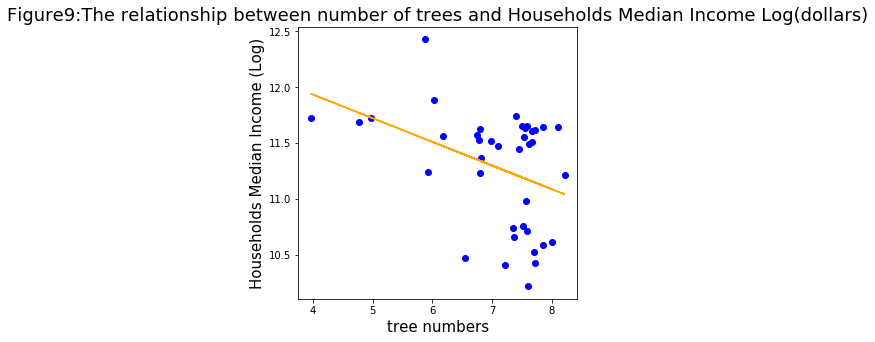

In [49]:
OLS1 = smf.ols(formula='y1  ~ x1', data = tree_econ).fit()
pl.figure(figsize=(5,5))
pl.plot(x1,y1,'bo')
pl.plot(x1, OLS1.predict(tree_econ),'-', color='orange')
plt.title('Figure9:The relationship between number of trees and Households Median Income Log(dollars)', fontsize=18)
plt.xlabel('tree numbers', fontsize=15)
plt.ylabel('Households Median Income (Log)', fontsize=15)

Figure 9: Not as expected, the household income and tree numbers has a negative relation.

### Scatter plot of number of trees with average rental price by zipcode 2015

In [52]:
x2 = np.log(tree_econ['ntrees'])
y2 = np.log(tree_econ['2015 Average Rental'])

Text(0.5,1,'Figure10: The relationship between number of trees and Community rental price')

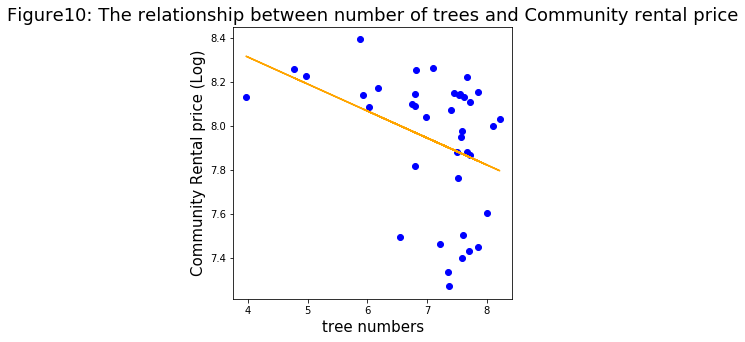

In [53]:
OLS2 = smf.ols(formula='y2  ~ x2', data = tree_econ).fit()
pl.figure(figsize=(5,5))
pl.plot(x2,y2,'bo')
pl.plot(x2, OLS2.predict(tree_econ),'-', color='orange')
plt.xlabel('tree numbers', fontsize=15)
plt.ylabel('Community Rental price (Log)', fontsize=15)
plt.title('Figure10: The relationship between number of trees and Community rental price', fontsize=18)

Figure 10: Not as expected, the community rental price and tree numbers has a negative relation.

# 6. Conclusion

There is no relationship between average tree health level and community households income or rental price. Besides, There is no relationship between average tree diameter and community households income or rental price.

The average total number of trees of a zipcode zone has weak negative relationship with community households income and rental price.